### Import library

In [7]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from statistics import mode

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.compose import make_column_transformer
from sklearn.pipeline import make_pipeline
from sklearn.metrics import mean_squared_error

### Load data

In [8]:
data = pd.read_pickle("C:/Users/ESTHER YOLANDA T/data.pk1")
data.head()

,status,card_present_flag,account,long_lat,txn_description,merchant_id,first_name,balance,date,gender,...,merchant_state,extraction,amount,transaction_id,customer_id,merchant_long_lat,movement,month,dayofweek,hour
0,authorized,1.0,ACC-1598451071,153.41 -27.95,POS,81c48296-73be-44a7-befa-d053f48ce7cd,Diana,35.39,2018-08-01,F,...,QLD,01:01:15,16.25,a623070bfead4541a6b0fff8a09e706c,CUS-2487424745,153.38 -27.99,debit,8,2,01
1,authorized,0.0,ACC-1598451071,153.41 -27.95,SALES-POS,830a451c-316e-4a6a-bf25-e37caedca49e,Diana,21.20,2018-08-01,F,...,NSW,01:13:45,14.19,13270a2a902145da9db4c951e04b51b9,CUS-2487424745,151.21 -33.87,debit,8,2,01
2,authorized,1.0,ACC-1222300524,151.23 -33.94,POS,835c231d-8cdf-4e96-859d-e9d571760cf0,Michael,5.71,2018-08-01,M,...,NSW,01:26:15,6.42,feb79e7ecd7048a5a36ec889d1a94270,CUS-2142601169,151.21 -33.87,debit,8,2,01
3,authorized,1.0,ACC-1037050564,153.10 -27.66,SALES-POS,48514682-c78a-4a88-b0da-2d6302e64673,Rhonda,2117.22,2018-08-01,F,...,QLD,01:38:45,40.90,2698170da3704fd981b15e64a006079e,CUS-1614226872,153.05 -26.68,debit,8,2,01
4,authorized,1.0,ACC-1598451071,153.41 -27.95,SALES-POS,b4e02c10-0852-4273-b8fd-7b3395e32eb0,Diana,17.95,2018-08-01,F,...,QLD,01:51:15,3.25,329adf79878c4cf0aeb4188b4691c266,CUS-2487424745,153.44 -28.06,debit,8,2,01


### Target variable

Collect all the unique customer ids and put it into a dataframe

In [9]:
#Check the salary payment of each customer
salary_df = pd.DataFrame({"customer_id": data.customer_id.unique()})
salary_df.head()

,customer_id
0,CUS-2487424745
1,CUS-2142601169
2,CUS-1614226872
3,CUS-2688605418
4,CUS-4123612273


In [11]:
df_freq = []
df_amount = []

for customer in range(len(salary_df)):
    salary = data.loc[(data.customer_id == salary_df.customer_id[customer]) & (data.txn_description == "PAY/SALARY"), ["date", "amount"]].groupby("date", as_index = False).sum()
    count = len(salary)
    if count == 0:
        df_amount.append(np.nan)
        df_freq.append(np.nan)
    else:
        days_between_payments = []
        for date in range(len(salary)-1):
            days_between_payments.append((salary.date[date + 1] - salary.date[date]).days)
        df_freq.append(max(days_between_payments))
        df_amount.append(mode(salary.amount))

salary_df["salary_freq"] = df_freq
salary_df["salary_amount"] = df_amount       
salary_df["annual_salary"] = salary_df["salary_amount"] / salary_df["salary_freq"] * 365.25
salary_df.head()

,customer_id,salary_freq,salary_amount,annual_salary
0,CUS-2487424745,7,1013.67,52891.852500
1,CUS-2142601169,7,1002.13,52289.711786
2,CUS-1614226872,7,892.09,46547.981786
3,CUS-2688605418,14,2320.30,60534.969643
4,CUS-4123612273,7,1068.04,55728.801429


C:\Users\ESTHER YOLANDA T\anaconda3\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


Text(0.5, 0, 'Annual salary')

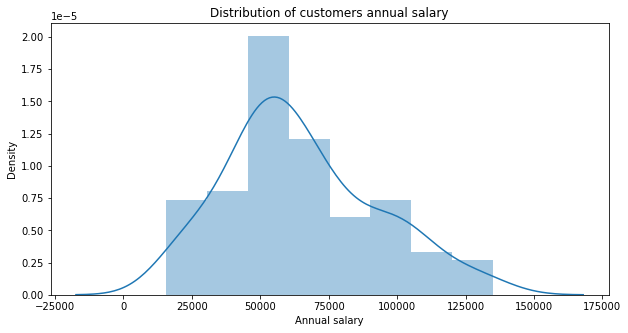

In [13]:
plt.figure(figsize = (10, 5))
sns.distplot(salary_df.annual_salary)
plt.title("Distribution of customers annual salary")
plt.xlabel("Annual salary")

#### Predictor variables

In [15]:
#Unique customer ids
unique_id = data.customer_id.unique()
len(unique_id)

100

In [17]:
#Average number -> weekly transactions
avg_weekly = []
for id_ in unique_id:
    array = data.loc[data.customer_id == id_, "date"]
    avg_weekly.append(round(len(array)/array.nunique()*7))
avg_weekly[:5]

[48, 29, 24, 14, 21]

In [19]:
#Maximum amount
max_amount = []
for id_ in unique_id:
    array = data.loc[data.customer_id == id_, "amount"]
    max_amount.append(max(array))
max_amount[:5]

[1452.21, 2349.55, 892.09, 2320.3, 1068.04]

In [20]:
#Number of >$100 transactions
not_large = []
for id_ in unique_id:
    count=0
    array=data.loc[data.customer_id == id_, "amount"]
    for amount in array:
        if amount > 100:
            count += 1
    not_large.append(count)
not_large[:5]

[22, 23, 22, 25, 32]

In [22]:
#Number of dsays with transactions
no_day = []
for id_ in unique_id:
    array=data.loc[data.customer_id == id_, "date"]
    no_day.append(array.nunique())
no_day[:5]

[85, 74, 76, 63, 44]

In [23]:
#Average transaction
avg_trx = []
for id_ in unique_id:
    array=data.loc[data.customer_id == id_, "amount"]
    avg_trx.append(array.mean())
avg_trx[:5]

[45.34877162629756,
 78.20610561056101,
 74.46501930501928,
 159.3041860465116,
 166.50835820895517]

In [24]:
#Median
median_blc = []
for id_ in unique_id:
    array=data.loc[data.customer_id == id_, "balance"]
    median_blc.append(array.median())
median_blc[:5]

[1580.4, 1132.66, 3618.5, 5616.63, 6162.45]

In [25]:
#State of residence
state = []
for id_ in unique_id:
    array=data.loc[data.customer_id == id_, "merchant_state"]
    state.append(mode(array))
state[:5]

['QLD', 'NSW', 'QLD', 'NSW', 'VIC']

In [26]:
#Age
age = []
for id_ in unique_id:
    array=data.loc[data.customer_id == id_, "age"]
    age.append(mode(array))
age[:5]

[26, 38, 40, 20, 43]

In [27]:
#Gender
gender = []
for id_ in unique_id:
    array=data.loc[data.customer_id == id_, "gender"]
    gender.append(mode(array))
gender[:5]

['F', 'M', 'F', 'M', 'F']

In [36]:
#Predictor variables
features_df = pd.DataFrame({"customer_id": unique_id,
                            "max_amount": max_amount,
                           "avg_weekly": avg_weekly,
                           "not_large": not_large,
                           "avg_trx": avg_trx,
                           "median_blc": median_blc,
                           "state": state,
                           "age": age,
                           "gender": gender})
features_df.head()

,customer_id,max_amount,avg_weekly,not_large,avg_trx,median_blc,state,age,gender
0,CUS-2487424745,1452.21,48,22,45.348772,1580.40,QLD,26,F
1,CUS-2142601169,2349.55,29,23,78.206106,1132.66,NSW,38,M
2,CUS-1614226872,892.09,24,22,74.465019,3618.50,QLD,40,F
3,CUS-2688605418,2320.30,14,25,159.304186,5616.63,NSW,20,M
4,CUS-4123612273,1068.04,21,32,166.508358,6162.45,VIC,43,F


In [37]:
#Target variables
salary_df.head()

,customer_id,salary_freq,salary_amount,annual_salary
0,CUS-2487424745,7,1013.67,52891.852500
1,CUS-2142601169,7,1002.13,52289.711786
2,CUS-1614226872,7,892.09,46547.981786
3,CUS-2688605418,14,2320.30,60534.969643
4,CUS-4123612273,7,1068.04,55728.801429


In [38]:
#Concat annual salary to features dataframe
df = pd.concat([features_df, salary_df.annual_salary], axis=1)
df.head()

,customer_id,max_amount,avg_weekly,not_large,avg_trx,median_blc,state,age,gender,annual_salary
0,CUS-2487424745,1452.21,48,22,45.348772,1580.40,QLD,26,F,52891.852500
1,CUS-2142601169,2349.55,29,23,78.206106,1132.66,NSW,38,M,52289.711786
2,CUS-1614226872,892.09,24,22,74.465019,3618.50,QLD,40,F,46547.981786
3,CUS-2688605418,2320.30,14,25,159.304186,5616.63,NSW,20,M,60534.969643
4,CUS-4123612273,1068.04,21,32,166.508358,6162.45,VIC,43,F,55728.801429


In [39]:
df.isnull().sum()

customer_id      0
max_amount       0
avg_weekly       0
not_large        0
avg_trx          0
median_blc       0
state            0
age              0
gender           0
annual_salary    0
dtype: int64

There's no missing values, it means a final dataframe is now readt for preprocessing and modelling

### Preprocessing

#### Data split
It will be splitted into data training and data testing, which 70% of the dataframe into training set and 30% of the dataframe into testing set

In [40]:
x = df.drop(["customer_id", "annual_salary"], axis=1)
y = df.annual_salary

print("x shape: ", x.shape)
print("y shape: ", y.shape)

x shape:  (100, 8)
y shape:  (100,)


In [41]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.3, random_state=42)

print("x_train shape: ", x_train.shape)
print("y_train shape: ", y_train.shape)
print("x_test shape: ", x_test.shape)
print("y_test shape: ", y_test.shape)

x_train shape:  (70, 8)
y_train shape:  (70,)
x_test shape:  (30, 8)
y_test shape:  (30,)


#### Transform the column with one-hot encoder and standard scaler
It should be scaled into a numerical variables because models can't train on varibales that contain text

In [48]:
onehot = OneHotEncoder(sparse=False)
scaler = StandardScaler()
column_transform = make_column_transformer((onehot, ["state", "gender"]), (scaler, ["avg_weekly", "max_amount", "not_large", "avg_trx", "median_blc", "age"]))

### Predict

Trying to predict with Linear Regression and Desicion Tree

#### Linear Regression

In [49]:
lr = LinearRegression()
lr_pipeline = make_pipeline(column_transform, lr)

In [50]:
lr_pipeline.fit(x_train, y_train)
lr_pred = lr_pipeline.predict(x_test)

In [51]:
print("RMSE: ", round(np.sqrt(mean_squared_error(lr_pred, y_test))))

RMSE:  27836


#### Decision Tree

In [52]:
dt = DecisionTreeRegressor()
dt_pipeline = make_pipeline(column_transform, dt)

In [53]:
dt_pipeline.fit(x_train, y_train)
dt_pred = dt_pipeline.predict(x_test)

In [54]:
print("RMSE: ", round(np.sqrt(mean_squared_error(dt_pred, y_test))))

RMSE:  21344
